### FastText KNN Classifier and Visualization
This notebook demonstrates a rudimentary text classification task using the sklearn implementation of the K-Nearest Neighbors classification algorithm. There is also includes ADASYN upsampling for imbalanced data and PCA dimensionality reduction for visualization.

In [24]:
import fasttext as ft
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from tqdm.notebook import tqdm
from collections import Counter
from imblearn.over_sampling import ADASYN
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from nltk.corpus import stopwords
import random
import re

In [34]:
stopwords = stopwords.words('english')

In [2]:
model = ft.load_model('C:/Users/Christian/Desktop/crawl-300d-2M-subword.bin')

In [36]:
df = pd.read_csv('res/bbc.csv')

In [37]:
# Arbitrary downsampling to demonstrate effects of ASASYN.
subsamples = [
    group.sample(i) for i, (name, group) in zip(random.sample(range(20, 200), k=len(df.label.unique())), df.groupby('label'))
]

In [38]:
df = pd.concat(subsamples).reset_index(drop=True)

In [39]:
def preprocess(text: str) -> list:
    tokens = []
    text = re.sub('[—;/()•,.\[\]\-\'0123456789]', ' ', text)
    for token in text.split():
        token = token.lower()
        if len(token) > 2 and token not in stopwords:
            tokens.append(token)
    
    return tokens

In [40]:
X, y = tuple(
    map(
        np.array, 
        list(
            zip(
                *[
                    (
                        np.mean(
                            [model[token] for token in preprocess(x.text)], 
                            axis=0
                        ),
                        x.label
                    ) for x in df.itertuples()
                ]
            )
        )
    )
)

In [41]:
# Resample using ADASYN.
data_res, labels_res = ADASYN(n_neighbors = 3).fit_sample(X, y)

In [42]:
print(f'Distribution before resampling: {Counter(y)}')
print(f'Distribution before resampling: {Counter(labels_res)}')

Distribution before resampling: Counter({'business': 183, 'politics': 89, 'entertainment': 43, 'tech': 41, 'sport': 36})
Distribution before resampling: Counter({'sport': 184, 'business': 183, 'entertainment': 183, 'politics': 180, 'tech': 179})


C:\Users\Christian\Anaconda3\envs\deepsight\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


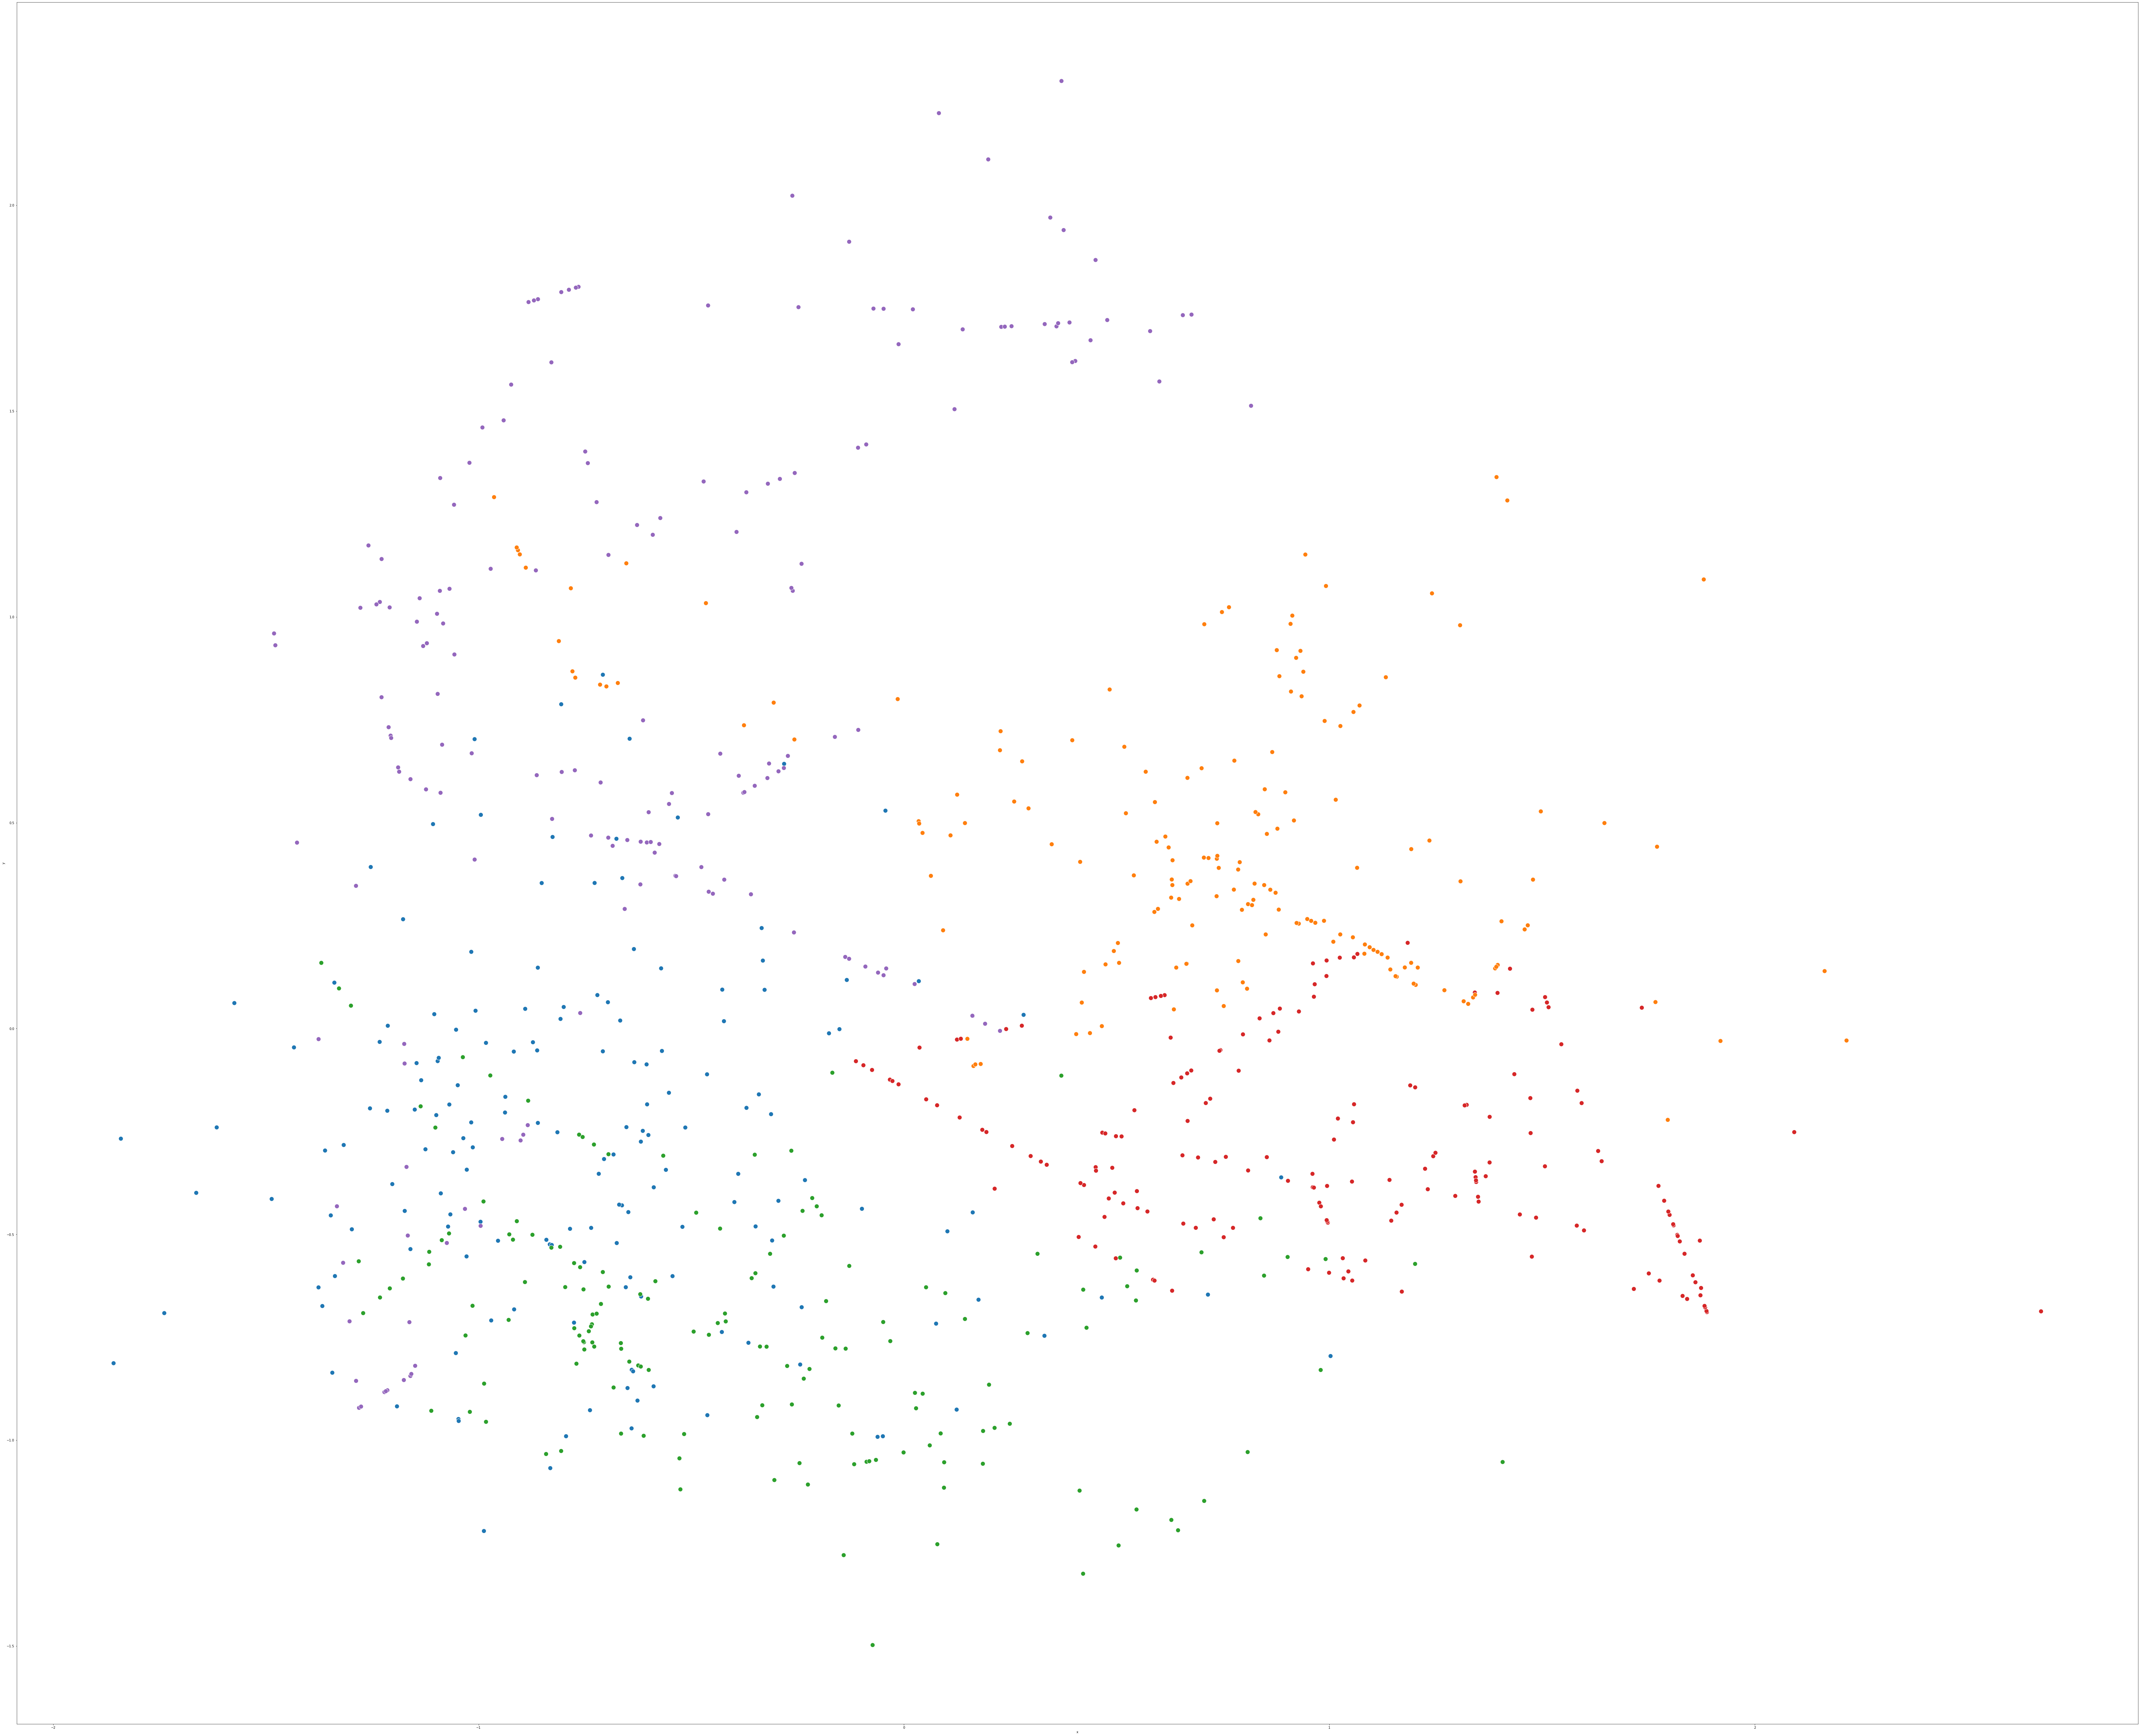

In [43]:
# Normalize values between 0 and 1. 
scaler = MinMaxScaler(feature_range=[0, 1])
data_rescaled = scaler.fit_transform(data_res)

# # Reduce dimensions.
pca = PCA(n_components=2)
data = pca.fit_transform(data_rescaled)

# Add everything to a new df.
df_new = pd.DataFrame([{'dimension': dimension} for dimension in labels_res])
df_new['x'] = data[:, 0]
df_new['y'] = data[:, 1]
df_new['keyword'] = ' '

# Plot the values.
plt.figure(figsize=(120, 100))
scatter = sns.scatterplot('x', # Horizontal axis
                   'y', # Vertical axis,
                   hue='dimension',
                   data=df_new, # Data source
                   s=200,
                   legend=False) 

plt.show()

In [44]:
# Organize into a df.
df_traintest = pd.DataFrame([{'data': tpl[0], 'label': tpl[1]} for tpl in zip(data_res, labels_res)]).sample(frac=1)

# Split dataset.
train, test = train_test_split(df_traintest, test_size=0.2)
train_data, train_labels, test_data, test_labels = train['data'].to_numpy(), train['label'].to_numpy(), \
                                                   test['data'].to_numpy(), test['label'].to_numpy()

print(f'Length of train data: {len(train)}, Length of test data: {len(test)}')

Length of train data: 727, Length of test data: 182


In [45]:
# Create KNN Classifier
knn = KNeighborsClassifier(n_neighbors=5)

# Train the model using the training sets.
knn.fit(list(train_data), list(train_labels))

# Predict the response for test dataset
y_pred = knn.predict(list(test_data))

# Evaluate model on test dataset.
print("Accuracy:", metrics.accuracy_score(test_labels, y_pred))

Accuracy: 0.9120879120879121
